<a href="https://colab.research.google.com/github/DinethRubeh/Cotton-Disease-Prediction/blob/master/Model_Training_CNN_Optimized.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import tensorflow as tf
print(tf.test.gpu_device_name())

/device:GPU:0


In [3]:
!nvidia-smi

Thu Oct  1 19:06:58 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.23.05    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P0    33W / 250W |    265MiB / 16280MiB |      4%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
!pip install tensorflow==2.2.0
!pip install keras-tuner

In [5]:
tf.__version__

'2.2.0'

In [6]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
# os.environ["CUDA_VISIBLE_DEVICES"] = ""
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [7]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# from kerastuner import HyperModel
from kerastuner import RandomSearch
from kerastuner.engine.hyperparameters import HyperParameters

import matplotlib.pyplot as plt

In [8]:
# Resize images
img_height = 224
img_width = 224
image_size = (img_height, img_width, 3) # height, width, depth

# Output classes
predict_class_size = 4

# Train/validation image path
train_dir = '/content/drive/My Drive/google colab/cotton_data/train'
test_dir = '/content/drive/My Drive/google colab/cotton_data/val'

# batch size
bs = 32

In [9]:
# Image Data Augmentation using keras ImageDataGenerator
train_gen = ImageDataGenerator(rescale=1./255, #rescale
                               rotation_range=30,  
                               zoom_range=0.2, # ~ [1-0.2, 1+0.2]
                               brightness_range=[0.5,1.5]) # <1 darkens img, >1 brightens img
# only scale the test images
test_gen = ImageDataGenerator(rescale=1./255)

In [10]:
# Create train/test set
train_set = train_gen.flow_from_directory(train_dir, target_size=(img_height,img_width), batch_size=bs, class_mode='categorical')
test_set = test_gen.flow_from_directory(test_dir, target_size=(img_height,img_width), batch_size=bs, class_mode='categorical')

Found 1951 images belonging to 4 classes.
Found 324 images belonging to 4 classes.


## **Keras Tuner Basics**

Here we are using **model-building function**. It takes an argument hp from which you can sample hyperparameters. Implemeted function below returns a compiled model.

Note: To put the whole hyperparameter search space together and perform hyperparameter tuning, Keras Tuners uses **HyperModel** instances. Hypermodels are reusable class object introduced with the library, defined as follows. https://keras-team.github.io/keras-tuner/#you-can-use-a-hypermodel-subclass-instead-of-a-model-building-function

#### **Defineing Search Space** - 
To perform hyperparameter tuning, we need to define the search space (i.e. which hyperparameters need to be optimized and in what range) Here, there are  5 hyperparameters that can be tuned in this CNN model:
 - convolutional layer -> number of filters
 - 3 dropout layers -> dropout rate 
 - dense layer -> number of units

##### **Hyperparameter type** - 
In Keras Tuner, hyperparameters have a type (possibilities are Float, Int, Boolean, and Choice) and a unique name. Then, a set of options to help guide the search need to be set:
 - a minimal, a maximal and a default value for the **Float** and the **Int** types
 - a set of possible values for the **Choice** type
 - a **sampling** method within linear, log or reversed log. (Setting this parameter allows to add prior knowledge you might have about the tuned parameter)
 - a **step value**, i.e the minimal step between two hyperparameter values

#### **Choosing the tuner** - 
Keras Tuner offers the main hyperparameter tuning methods: Random Search, Hyperband, and Bayesian optimization.
 - **RandomSearch** - randomly sample hyperparameter combinations and test them out.
 - **Hyperband** - an optimized version of random search which uses early-stopping to speed up the hyperparameter tuning process. The main idea is to fit a large number of models for a small number of epochs and to only continue training for the models achieving the highest accuracy on the validation set
 - **Bayesian Optimization** - a probabilistic model that maps the hyperparameters to a probability score on the objective function. Unlike Random Search and Hyperband models, Bayesian Optimization keeps track of its past evaluation results and uses it to build the probability model.

Note - To select the best performing tuner among multiple tuners, we can use best model MSE of each tuner.

In [11]:
def build_model(hp):

  ''' Model Building'''
  ## Sequential model
  model = Sequential()
  ## Convolutional block 1
  model.add(Conv2D(filters=16, kernel_size=3, activation='relu', input_shape=image_size))
  model.add(Conv2D(filters=16, kernel_size=3, activation='relu'))
  model.add(MaxPooling2D(pool_size=2))
  # model.add(Dropout(0.4))
  model.add(Dropout(
      rate=hp.Float('dropout_1', min_value=0.0, max_value=0.5, default=0.25, step=0.05)
      ))
  
  ## Convolutional block 2
  model.add(Conv2D(filters=32, kernel_size=3, activation='relu', input_shape=image_size))
  # model.add(Conv2D(filters=32, kernal_size=3, activation='relu'))
  model.add(Conv2D(
      filters=hp.Choice('num_filters', values=[32,64], default=64),
      kernel_size=3, 
      activation='relu'
      ))
  model.add(MaxPooling2D(pool_size=2))
  # model.add(Dropout(0.4))
  model.add(Dropout(
      rate=hp.Float('dropout_2', min_value=0.0, max_value=0.5, default=0.25, step=0.05)
      ))
  
  ## flatten layer
  model.add(Flatten())

  ## Fully connected layer
  # model.add(Dense(128, activation='relu'))
  # model.add(Dropout(0.4))
  model.add(Dense(
      units=hp.Int('units', min_value=32, max_value=512, default=128, step=32),
      activation='relu'
      ))
  model.add(Dropout(
      rate=hp.Float('dropout_3', min_value=0.0, max_value=0.5, default=0.25, step=0.05)
      ))

  ## Softmax layer
  model.add(Dense(predict_class_size, activation='softmax'))

  '''Model Compiling'''
  # optimizer
  # opt = Adam(lr=1e-4)
  opt = Adam(
      lr=hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, default=1e-3, sampling='LOG') # usually the learning rate is chosen on a log scale
  )
  model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

  return model

***Note***: 
 - **Stacking convnets** usually leads to **less information being lost** in processing; (eg. "all convolutional" architectures)
 - Stacked conv layers have more flexibility in expressing non-linear transformations without loosing information. In above Convolutional block,  Maxpool removes information from the signal, dropout forces distributed representation, thus both effectively make it harder to propagate information.
 - If, for given problem, highly non-linear transformation has to be applied on raw data, stacking multiple convs (with relu) will make it easier to learn.


In [12]:
# Lets use random search tuner
tuner = RandomSearch(
    build_model,
    objective='val_accuracy', # objective is the function to optimize
    max_trials=5, # number of hyperparameter combinations that will be tested by the tuner
    executions_per_trial=3, #  number of models that should be built and fit for each trial for robustness purposes
    directory='hp_random_search',
    project_name="cotton disease classification")

INFO:tensorflow:Reloading Oracle from existing project hp_random_search/cotton disease classification/oracle.json


In [13]:
# summary of the search space
tuner.search_space_summary()

In [14]:
# start tuning -> search method
tuner.search(train_set, 
             steps_per_epoch=len(train_set), 
             epochs=3, 
             validation_data=test_set, 
             validation_steps=len(test_set)
            )

Epoch 1/3
61/61 [==============================] - 697s 11s/step - loss: 1.2434 - accuracy: 0.4516 - val_loss: 1.0086 - val_accuracy: 0.5556
Epoch 2/3
61/61 [==============================] - 37s 610ms/step - loss: 0.9001 - accuracy: 0.6571 - val_loss: 0.8462 - val_accuracy: 0.6667
Epoch 3/3
61/61 [==============================] - 38s 616ms/step - loss: 0.7368 - accuracy: 0.7217 - val_loss: 0.6531 - val_accuracy: 0.7654
Epoch 1/3
61/61 [==============================] - 37s 604ms/step - loss: 1.3591 - accuracy: 0.4003 - val_loss: 1.0617 - val_accuracy: 0.5432
Epoch 2/3
61/61 [==============================] - 37s 604ms/step - loss: 1.0306 - accuracy: 0.5705 - val_loss: 0.8731 - val_accuracy: 0.6420
Epoch 3/3
61/61 [==============================] - 37s 601ms/step - loss: 0.8457 - accuracy: 0.6935 - val_loss: 0.6786 - val_accuracy: 0.7346
Epoch 1/3
61/61 [==============================] - 37s 606ms/step - loss: 1.5265 - accuracy: 0.4357 - val_loss: 1.0823 - val_accuracy: 0.5370
Epoch 2

Epoch 1/3
61/61 [==============================] - 38s 623ms/step - loss: 1.6809 - accuracy: 0.3906 - val_loss: 1.3347 - val_accuracy: 0.3519
Epoch 2/3
61/61 [==============================] - 38s 621ms/step - loss: 1.0758 - accuracy: 0.5433 - val_loss: 1.0164 - val_accuracy: 0.5463
Epoch 3/3
61/61 [==============================] - 38s 621ms/step - loss: 0.9531 - accuracy: 0.6243 - val_loss: 0.9530 - val_accuracy: 0.6667
Epoch 1/3
61/61 [==============================] - 37s 603ms/step - loss: 1.5019 - accuracy: 0.3808 - val_loss: 1.3343 - val_accuracy: 0.4198
Epoch 2/3
61/61 [==============================] - 37s 602ms/step - loss: 1.1856 - accuracy: 0.4746 - val_loss: 1.1499 - val_accuracy: 0.4907
Epoch 3/3
61/61 [==============================] - 37s 603ms/step - loss: 1.0328 - accuracy: 0.5484 - val_loss: 0.9700 - val_accuracy: 0.6080
Epoch 1/3
61/61 [==============================] - 37s 603ms/step - loss: 1.6127 - accuracy: 0.4024 - val_loss: 1.2255 - val_accuracy: 0.4877
Epoch 

Epoch 1/3
61/61 [==============================] - 38s 621ms/step - loss: 1.4849 - accuracy: 0.3849 - val_loss: 1.2223 - val_accuracy: 0.4938
Epoch 2/3
61/61 [==============================] - 38s 620ms/step - loss: 1.0835 - accuracy: 0.5433 - val_loss: 0.9792 - val_accuracy: 0.5833
Epoch 3/3
61/61 [==============================] - 38s 621ms/step - loss: 0.9658 - accuracy: 0.6084 - val_loss: 0.8460 - val_accuracy: 0.6389
Epoch 1/3
61/61 [==============================] - 37s 604ms/step - loss: 1.4318 - accuracy: 0.4254 - val_loss: 1.2225 - val_accuracy: 0.4414
Epoch 2/3
61/61 [==============================] - 37s 602ms/step - loss: 1.0279 - accuracy: 0.5997 - val_loss: 0.9049 - val_accuracy: 0.6327
Epoch 3/3
61/61 [==============================] - 38s 619ms/step - loss: 0.8858 - accuracy: 0.6520 - val_loss: 0.7700 - val_accuracy: 0.7099
Epoch 1/3
61/61 [==============================] - 37s 603ms/step - loss: 1.5597 - accuracy: 0.3936 - val_loss: 1.3104 - val_accuracy: 0.3117
Epoch 

Epoch 1/3
61/61 [==============================] - 38s 627ms/step - loss: 1.4225 - accuracy: 0.3998 - val_loss: 1.2941 - val_accuracy: 0.4444
Epoch 2/3
61/61 [==============================] - 38s 630ms/step - loss: 1.0763 - accuracy: 0.5572 - val_loss: 1.0550 - val_accuracy: 0.5802
Epoch 3/3
61/61 [==============================] - 38s 628ms/step - loss: 0.9919 - accuracy: 0.5869 - val_loss: 0.9955 - val_accuracy: 0.6049
Epoch 1/3
61/61 [==============================] - 37s 602ms/step - loss: 1.6268 - accuracy: 0.3660 - val_loss: 1.3591 - val_accuracy: 0.3117
Epoch 2/3
61/61 [==============================] - 37s 599ms/step - loss: 1.2686 - accuracy: 0.4305 - val_loss: 1.2923 - val_accuracy: 0.3858
Epoch 3/3
61/61 [==============================] - 36s 597ms/step - loss: 1.1071 - accuracy: 0.5115 - val_loss: 1.1419 - val_accuracy: 0.4907
Epoch 1/3
61/61 [==============================] - 37s 602ms/step - loss: 1.9063 - accuracy: 0.3721 - val_loss: 1.3088 - val_accuracy: 0.3179
Epoch 

Epoch 1/3
61/61 [==============================] - 37s 610ms/step - loss: 1.2728 - accuracy: 0.4300 - val_loss: 1.0501 - val_accuracy: 0.5185
Epoch 2/3
61/61 [==============================] - 37s 605ms/step - loss: 0.9810 - accuracy: 0.5710 - val_loss: 0.8823 - val_accuracy: 0.6512
Epoch 3/3
61/61 [==============================] - 38s 619ms/step - loss: 0.8616 - accuracy: 0.6438 - val_loss: 0.7299 - val_accuracy: 0.7346
Epoch 1/3
61/61 [==============================] - 37s 600ms/step - loss: 1.4786 - accuracy: 0.4295 - val_loss: 1.2125 - val_accuracy: 0.5123
Epoch 2/3
61/61 [==============================] - 36s 596ms/step - loss: 0.9964 - accuracy: 0.5930 - val_loss: 0.9413 - val_accuracy: 0.5864
Epoch 3/3
61/61 [==============================] - 37s 604ms/step - loss: 0.8892 - accuracy: 0.6643 - val_loss: 0.7528 - val_accuracy: 0.7377
Epoch 1/3
61/61 [==============================] - 36s 598ms/step - loss: 1.4758 - accuracy: 0.3844 - val_loss: 1.3238 - val_accuracy: 0.3395
Epoch 

INFO:tensorflow:Oracle triggered exit


In [15]:
# Show a summary of the search
tuner.results_summary()

In [16]:
# Retrieve the best model.
model = tuner.get_best_models(num_models=1)[0]
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 222, 222, 16)      448       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 220, 220, 16)      2320      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 110, 110, 16)      0         
_________________________________________________________________
dropout (Dropout)            (None, 110, 110, 16)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 108, 108, 32)      4640      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 106, 106, 32)      9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 53, 53, 32)        0

#### Fully train the best model

Note: This is because of the limited resources, otherwise we can increase the epochs, max_trials, executions_per_trial in keras tuner and complete this.

In [17]:
# fit data for best model
# model.fit(train_images, train_labels, epochs=10, validation_split=0.1, initial_epoch=3)
hist = model.fit_generator(train_set, 
                          epochs=20,
                          steps_per_epoch=len(train_set),
                          validation_data=test_set,
                          validation_steps=len(test_set)
                         )

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/20
61/61 [==============================] - 37s 601ms/step - loss: 0.6646 - accuracy: 0.7412 - val_loss: 0.5570 - val_accuracy: 0.8117
Epoch 2/20
61/61 [==============================] - 36s 597ms/step - loss: 0.5995 - accuracy: 0.7775 - val_loss: 0.5330 - val_accuracy: 0.8148
Epoch 3/20
61/61 [==============================] - 36s 596ms/step - loss: 0.5666 - accuracy: 0.7750 - val_loss: 0.5965 - val_accuracy: 0.7654
Epoch 4/20
61/61 [==============================] - 36s 598ms/step - loss: 0.5392 - accuracy: 0.7934 - val_loss: 0.5556 - val_accuracy: 0.8117
Epoch 5/20
61/61 [==============================] - 37s 602ms/step - loss: 0.5324 - accuracy: 0.8057 - val_loss: 0.5464 - val_accuracy: 0.7870
Epoch 6/20
61/61 [==============================] - 36s 597ms/step - loss: 0.4638 - accuracy: 0.8232 - val_loss: 0.4383 - val_accuracy: 0.8457
Epoch 7/20
61/61 [==============================] - 36s 597ms/step

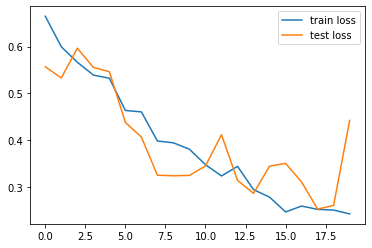

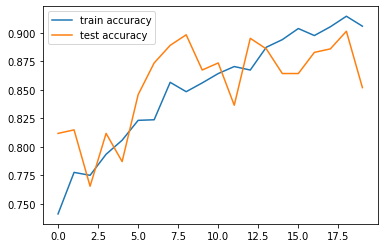

<Figure size 432x288 with 0 Axes>

In [18]:
## Plot loss
plt.plot(hist.history['loss'], label='train loss')
plt.plot(hist.history['val_loss'], label='test loss')
plt.legend()
plt.show()
plt.savefig('/content/drive/My Drive/google colab/cotton_data/models/loss_opt_cnn')
plt.clf()

## Plot Accuracy
plt.plot(hist.history['accuracy'], label='train accuracy')
plt.plot(hist.history['val_accuracy'], label='test accuracy')
plt.legend()
plt.show()
plt.savefig('/content/drive/My Drive/google colab/cotton_data/models/accuracy_opt_cnn')
plt.clf()

In [19]:
# save cnn model
model.save('/content/drive/My Drive/google colab/cotton_data/models/model_cnn_opt.h5')